In [1]:
import jax.numpy as jnp
import jax.random as jr
import jax

import imageio
import os

In [2]:
def boids_simulation(num_boids, num_steps, seperation, separation_radius, alignment, 
                     alignment_radius, cohesion, cohesion_radius, rng_key, pheromone_sensitivity, 
                     pheromone_radius=10, space_size=50.0, max_velocity=0.2, min_velocity=0.05, 
                     avoid_edges=False, edge_avoidance_strength=1.0, pheromone_fraction=0.2, 
                     pheromone_decay=0.0005, pheromone_deposit_interval=10, FOV=jnp.pi/2, 
                     elevation_function=None, elevation_strength=1.0):
    """ 
    Simulate the movement of boids in a 2D toroidal space with velocity constraints and pheromone behavior.
    
    Args:
        num_boids (int): Number of boids in the simulation.
        num_steps (int): Number of simulation steps.
        seperation (float): Weight for the separation behavior.
        separation_radius (float): Radius for the separation behavior.
        alignment (float): Weight for the alignment behavior.
        alignment_radius (float): Radius for the alignment behavior.
        cohesion (float): Weight for the cohesion behavior.
        cohesion_radius (float): Radius for the cohesion behavior.
        rng_key (jax.random.PRNGKey): Random key for initialization.
        space_size (float): Size of the 2D toroidal space.
        max_velocity (float): Maximum allowed velocity magnitude.
        min_velocity (float): Minimum allowed velocity magnitude.
        avoid_edges (bool): Whether to apply edge avoidance behavior.
        edge_avoidance_strength (float): Strength of the edge avoidance force.
        pheromone_fraction (float): Fraction of boids that deposit pheromones.
        pheromone_decay (float): Rate at which pheromones decay over time.
        pheromone_deposit_interval (int): Interval at which pheromone boids deposit pheromones.

    Returns:
        position_history (jax.numpy.ndarray): History of positions at each step.
        velocity_history (jax.numpy.ndarray): History of velocities at each step.
        pheromone_history (jax.numpy.ndarray): History of pheromone grid at each step.
        positions (jax.numpy.ndarray): Final positions of the boids.
        velocities (jax.numpy.ndarray): Final velocities of the boids.
    """
    
    # Initialize positions and velocities of boids
    key, subkey1, subkey2 = jr.split(rng_key, 3)
    positions = jr.uniform(subkey1, (num_boids, 2), minval=0.0, maxval=space_size)
    velocities = jr.uniform(subkey2, (num_boids, 2), minval=-0.1, maxval=0.1)
    
    # Initialize pheromone grid
    pheromone_grid = jnp.zeros((int(space_size), int(space_size)))
    
    # Assign boids to pheromone depositors or seekers
    pheromone_boids = jnp.arange(num_boids) < int(num_boids * pheromone_fraction)
    
    def step(carry, t):
        positions, velocities, pheromone_grid = carry
        diff = positions[:, None, :] - positions[None, :, :]  # Pairwise differences (j - i) from boid i to j
        distances = jnp.linalg.norm(diff, axis=-1)  # Pairwise distances

        # Masks for different radii
        separation_mask = (distances < separation_radius)
        alignment_mask = (distances < alignment_radius)
        cohesion_mask = (distances < cohesion_radius)

        # Check for viewing angle
        vel_unit = velocities / jnp.linalg.norm(velocities, axis=1, keepdims=True)  # Normalize velocity
        diff_unit = diff / (distances[..., None] + 1e-8)  # Normalize pairwise differences
        cos_angles = jnp.einsum('ij,ikj->ik', vel_unit, diff_unit)  # Cosine of angles
        angle_mask = cos_angles > jnp.cos(FOV)

        # Apply angle mask to behaviors
        separation_mask = separation_mask & angle_mask
        alignment_mask = alignment_mask & angle_mask
        cohesion_mask = cohesion_mask & angle_mask

        # Separation: Avoid nearby boids
        separation_vector = jnp.sum(jnp.where(separation_mask[..., None], -diff, 0.0), axis=1)

        # Alignment: Match velocity with neighbors
        mask_sum = jnp.sum(alignment_mask, axis=1, keepdims=True)
        local_avg_velocity = jnp.where(mask_sum > 0, 
                                       jnp.sum(jnp.where(alignment_mask[..., None], velocities[None, :, :], 0.0), axis=1) / mask_sum, 
                                       velocities)
        alignment_vector = local_avg_velocity - velocities

        # Cohesion: Move toward local center of mass
        local_center_of_mass = jnp.where(mask_sum > 0, 
                                         jnp.sum(jnp.where(cohesion_mask[..., None], positions[None, :, :], 0.0), axis=1) / mask_sum, 
                                         positions)
        cohesion_vector = local_center_of_mass - positions

        # Edge avoidance: Push boids away from edges
        edge_avoidance_vector = jnp.zeros_like(positions)
        if avoid_edges:
            edge_threshold = space_size * 0.1
            edge_avoidance_vector += jnp.where(positions < edge_threshold, edge_avoidance_strength * (edge_threshold - positions), 0.0)
            edge_avoidance_vector += jnp.where(positions > space_size - edge_threshold, edge_avoidance_strength * (space_size - edge_threshold - positions), 0.0)

        # Elevation force: Compute gradient of elevation and apply as a force
        elevation_vector = jnp.zeros_like(positions)
        if elevation_function is not None:
            grad_elevation = jax.vmap(jax.grad(lambda pos: elevation_function(pos[0], pos[1])))(positions)
            elevation_vector = -elevation_strength * grad_elevation  # Negative gradient to move downhill

        # Pheromone behavior
        def deposit_pheromones(_):
            deposit_positions = positions[pheromone_boids].astype(int)
            return pheromone_grid.at[deposit_positions[:, 0], deposit_positions[:, 1]].add(1.0)

        pheromone_grid = jax.lax.cond(
            t % pheromone_deposit_interval == 0,
            deposit_pheromones,
            lambda _: pheromone_grid,
            operand=None
        )

        # Pheromone seeking behavior
        seeking_boids = ~pheromone_boids

        def get_pheromone_vector_grid_method(pheromone_grid, positions, velocities, seeking_boids, pheromone_radius):
            patch_radius = int(pheromone_radius)
            patch_size = 2 * patch_radius + 1
            grid_size = pheromone_grid.shape[0]  # Assume square grid

            # Pad grid for toroidal wrapping
            padded_grid = jnp.pad(pheromone_grid, patch_radius, mode='wrap')

            # Compute integer positions and adjust for padding
            boid_pos = positions.astype(int) + patch_radius  # Shape (N, 2)

            # Create offset indices for patch
            offsets = jnp.arange(-patch_radius, patch_radius + 1)
            dx, dy = jnp.meshgrid(offsets, offsets, indexing='ij')  # Shape (patch_size, patch_size)

            dx = dx.reshape(-1)
            dy = dy.reshape(-1)

            def get_patch_gradient(pos, vel):
                x, y = pos

                # Compute patch indices
                patch_x = x + dx  # shape (patch_size**2,)
                patch_y = y + dy

                # Gather values
                patch_vals = padded_grid[patch_x, patch_y].reshape(patch_size, patch_size)

                # Compute gradients
                grad_y, grad_x = jnp.gradient(patch_vals)

                grad_vec = jnp.array([grad_x[patch_radius, patch_radius], grad_y[patch_radius, patch_radius]])

                # Angle mask: only apply if gradient is in FOV
                vel_norm = vel / (jnp.linalg.norm(vel) + 1e-8)
                grad_norm = grad_vec / (jnp.linalg.norm(grad_vec) + 1e-8)
                cos_angle = jnp.dot(vel_norm, grad_norm)
                in_fov = cos_angle > jnp.cos(FOV)

                return jnp.where(in_fov, grad_vec, jnp.zeros_like(grad_vec))

            pheromone_vector = jax.vmap(get_patch_gradient)(boid_pos, velocities)

            # Apply only to seekers
            pheromone_vector = jnp.where(seeking_boids[:, None], pheromone_vector, 0.0)

            return pheromone_vector

        pheromone_vector = get_pheromone_vector_grid_method(pheromone_grid, positions, velocities, seeking_boids, pheromone_radius)

        # Update velocities
        velocities += (seperation * separation_vector +
                       alignment * alignment_vector +
                       cohesion * cohesion_vector +
                       edge_avoidance_vector +
                       pheromone_sensitivity * pheromone_vector +
                       elevation_vector) / num_boids

        # Clamp velocities to the specified range
        velocity_magnitudes = jnp.linalg.norm(velocities, axis=1, keepdims=True)
        velocities = jnp.where(velocity_magnitudes > max_velocity, velocities * (max_velocity / velocity_magnitudes), velocities)
        velocities = jnp.where(velocity_magnitudes < min_velocity, velocities * (min_velocity / velocity_magnitudes), velocities)

        # Update positions
        positions += velocities

        # Apply toroidal wrapping
        positions = jnp.mod(positions, space_size)

        # Decay pheromones
        pheromone_grid *= (1 - pheromone_decay)

        return (positions, velocities, pheromone_grid), (positions, velocities, pheromone_grid)
    
    # Use lax.scan to run the simulation for the specified number of steps
    (final_positions, final_velocities, final_pheromone_grid), (position_history, velocity_history, pheromone_history) = jax.lax.scan(
        step, (positions, velocities, pheromone_grid), jnp.arange(num_steps)
    )
    
    return position_history, velocity_history, pheromone_history, final_positions, final_velocities

In [7]:
# Define an elevation function (e.g., a Gaussian hill)
def elevation_function(x, y):
    center_x, center_y = 0.0, 0.0  # Center of the hill
    height = 50.0  # Maximum height of the hill
    spread = 50.0  # Spread of the hill
    gaussian1 = height * jnp.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * spread**2))
    center_x, center_y = 200.0, 200.0  # Center of the hill
    gaussian2 = height * jnp.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * spread**2))
    return gaussian1 + gaussian2

# Simulation parameters
num_boids = 400
num_steps = 1000
seperation = -0.3
alignment = 0.4
cohesion = 0.3
pheromone_sensitivity = 1
separation_radius = 2
alignment_radius = 8
cohesion_radius = 8
pheromone_radius = 12
rng_key = jr.PRNGKey(10)
space_size = 200.0

# Enable edge avoidance
avoid_edges = False
edge_avoidance_strength = 1.0

# Run the simulation with the elevation function
position_history, velocity_history, pheromone_history, final_positions, final_velocities = boids_simulation(
    num_boids=num_boids,
    num_steps=num_steps,
    seperation=seperation,
    separation_radius=separation_radius,
    alignment=alignment,
    alignment_radius=alignment_radius,
    cohesion=cohesion,
    cohesion_radius=cohesion_radius,
    rng_key=rng_key,
    pheromone_sensitivity=pheromone_sensitivity,
    pheromone_radius=pheromone_radius,
    space_size=space_size,
    avoid_edges=avoid_edges,
    edge_avoidance_strength=edge_avoidance_strength,
    elevation_function=elevation_function,  # Add the elevation function
    elevation_strength=1.0  # Strength of the elevation force
)

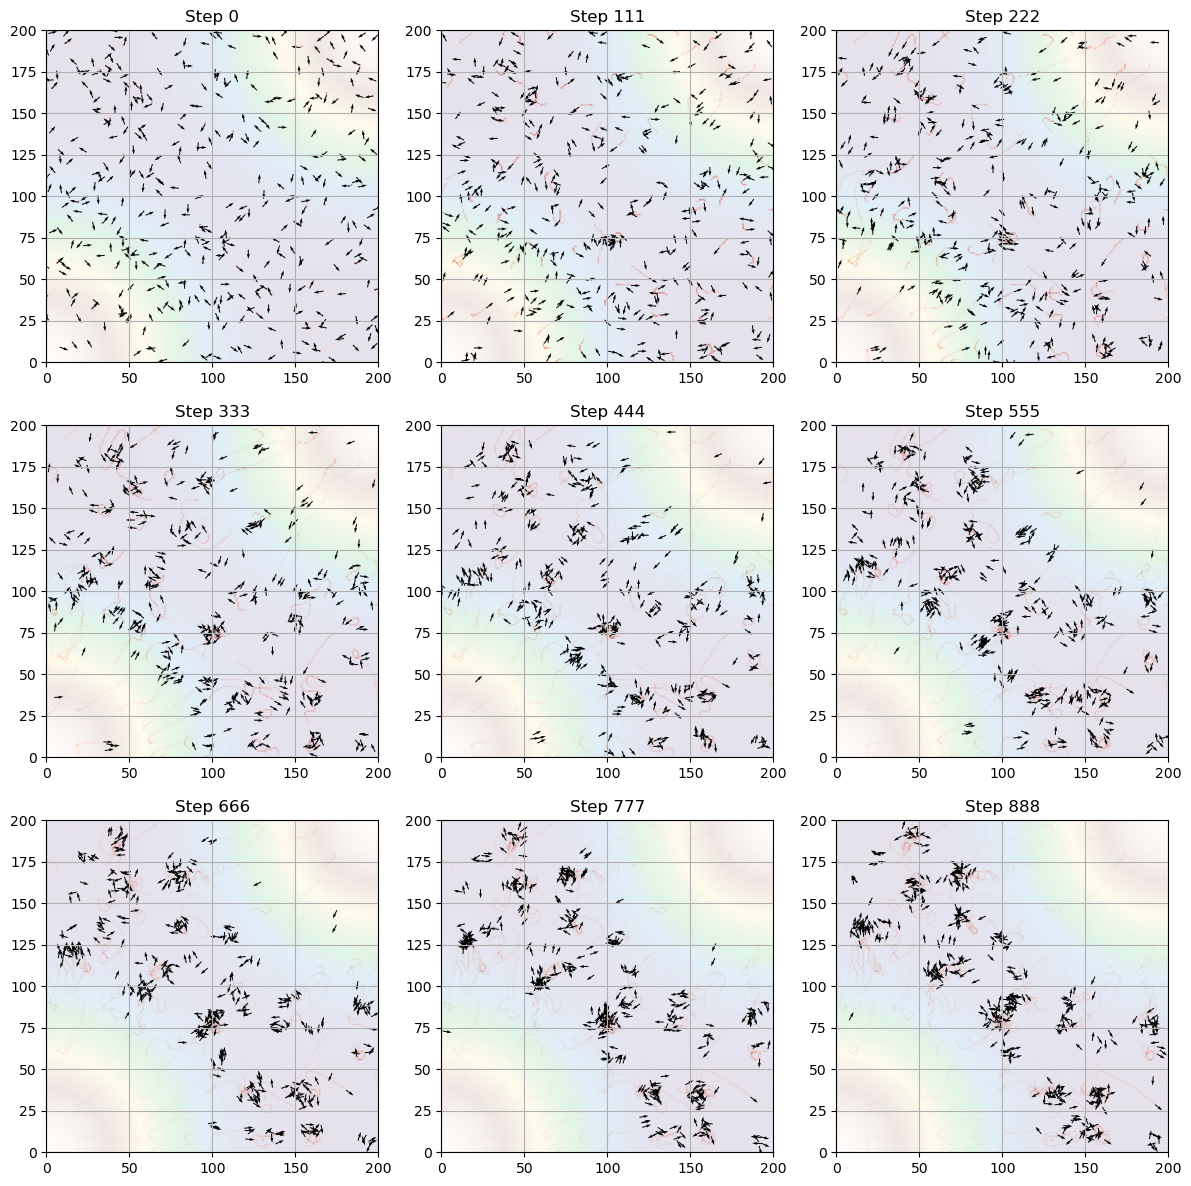

In [8]:
# Plot the positions, velocities, pheromone history, and terrain
import matplotlib.pyplot as plt
import numpy as np

# Convert JAX arrays to NumPy for plotting
position_history_np = np.array(position_history)
velocity_history_np = np.array(velocity_history)
pheromone_history_np = np.array(pheromone_history)

# Normalize the velocities for color mapping
abs_velocities = np.linalg.norm(velocity_history_np, axis=-1)
velocity_history_np = velocity_history_np / (abs_velocities[..., None] + 1e-8)  # Normalize to unit vectors

# Create a grid for the terrain
x = np.linspace(0, space_size, 200)
y = np.linspace(0, space_size, 200)
X, Y = np.meshgrid(x, y)
Z = np.array([[elevation_function(x, y) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Plot the simulation at 9 different time points in a 3x3 grid
use_velocity = True
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    step = i * (num_steps // 9)
    ax.set_title(f"Step {step}")
    ax.set_aspect('equal')
    ax.grid()

    # Plot the terrain as a heatmap
    ax.imshow(Z.T, origin='lower', cmap='terrain', alpha=0.2, extent=(0, space_size, 0, space_size))

    # Plot the pheromone grid as a red heatmap with alpha indicating decay
    pheromone_grid = pheromone_history_np[step]
    ax.imshow(pheromone_grid.T, origin='lower', cmap='Reds', alpha=0.4, extent=(0, space_size, 0, space_size))

    # Plot the boids
    if use_velocity:
        ax.quiver(position_history_np[step, :, 0], position_history_np[step, :, 1],
                  velocity_history_np[step, :, 0], velocity_history_np[step, :, 1],
                  angles='xy', scale_units='xy')
    else:
        ax.scatter(position_history_np[step, :, 0], position_history_np[step, :, 1], c='blue', s=1)

plt.tight_layout()
plt.show()

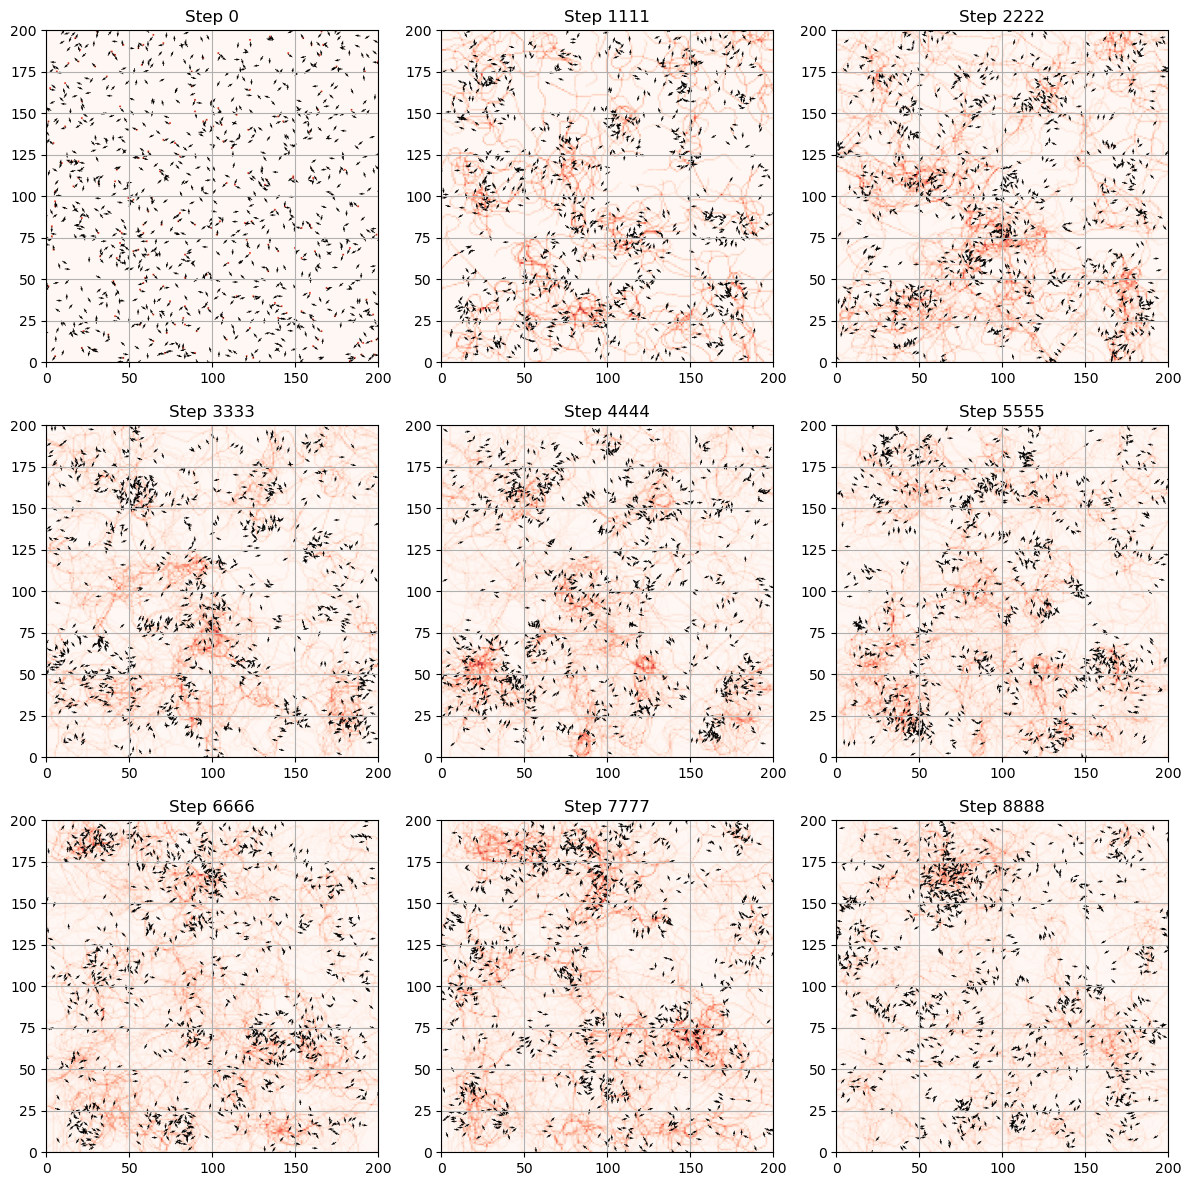

In [21]:
# Plot the positions and use the color for the velocities and pheromone history
import matplotlib.pyplot as plt
import numpy as np

# Convert JAX arrays to NumPy for plotting
position_history_np = np.array(position_history)
velocity_history_np = np.array(velocity_history)
pheromone_history_np = np.array(pheromone_history)

# Normalize the velocities for color mapping
abs_velocities = np.linalg.norm(velocity_history_np, axis=-1)
velocity_history_np = velocity_history_np / (abs_velocities[..., None] + 1e-8)  # Normalize to unit vectors

# Plot the simulation at 9 different time points in a 3x3 grid
use_velocity = True
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    step = i * (num_steps // 9)
    ax.set_title(f"Step {step}")
    ax.set_aspect('equal')
    ax.grid()

    # Plot the pheromone grid as a red heatmap with alpha indicating decay
    pheromone_grid = pheromone_history_np[step]
    ax.imshow(pheromone_grid.T, origin='lower', cmap='Reds', alpha=0.8, extent=(0, space_size, 0, space_size))

    # Plot the boids
    if use_velocity:
        ax.quiver(position_history_np[step, :, 0], position_history_np[step, :, 1],
                  velocity_history_np[step, :, 0], velocity_history_np[step, :, 1],
                  angles='xy', scale_units='xy')
    else:
        ax.scatter(position_history_np[step, :, 0], position_history_np[step, :, 1], c='blue', s=1)

plt.tight_layout()
plt.show()

In [22]:
def create_gif(position_history, velocity_history, pheromone_history, filename='boids_simulation.gif', fps=5, frame_step=10, use_arrows=True, window_size=100.0, space_size=100.0):
    """
    Create a GIF from the boids simulation with pheromone visualization.
    
    Args:
        position_history (jax.numpy.ndarray): History of positions at each step.
        velocity_history (jax.numpy.ndarray): History of velocities at each step.
        pheromone_history (jax.numpy.ndarray): History of pheromone grid at each step.
        filename (str): Name of the output GIF file.
        fps (int): Frames per second for the GIF.
        frame_step (int): Step size for selecting frames (e.g., every nth frame).
        use_arrows (bool): Whether to use arrows to represent velocities.
        window_size (float): Size of the plotting window.
        space_size (float): Size of the simulation space.
    """
    # Convert JAX arrays to NumPy for plotting
    position_history_np = np.array(position_history)
    velocity_history_np = np.array(velocity_history)
    pheromone_history_np = np.array(pheromone_history)

    # Normalize the velocities for consistent arrow scaling
    abs_velocities = np.linalg.norm(velocity_history_np, axis=-1)
    velocity_history_np = velocity_history_np / (abs_velocities[..., None] + 1e-8)  # Normalize to unit vectors

    images = []
    for i in range(0, position_history_np.shape[0], frame_step):
        fig, ax = plt.subplots()
        ax.set_xlim(0, window_size)
        ax.set_ylim(0, window_size)
        ax.set_aspect('equal')
        ax.set_xticks(np.arange(0, window_size + window_size % 10, window_size // 10))
        ax.set_yticks(np.arange(0, window_size + window_size % 10, window_size // 10))
        ax.grid()

        # Plot the pheromone grid as a red heatmap with alpha indicating decay
        pheromone_grid = pheromone_history_np[i]
        ax.imshow(pheromone_grid.T, origin='lower', cmap='Reds', alpha=0.5, extent=(0, space_size, 0, space_size))

        # Plot the boids
        if use_arrows:
            ax.quiver(position_history_np[i, :, 0], position_history_np[i, :, 1],
                      velocity_history_np[i, :, 0], velocity_history_np[i, :, 1],
                      angles='xy', scale_units='xy', color='blue')  # Fixed scale and width #scale=space_size/10, width=space_size/10000,
        else:
            ax.scatter(position_history_np[i, :, 0], position_history_np[i, :, 1], c='blue', s=10)

        plt.title(f"Step {i}")
        plt.tight_layout()

        # Save the current frame
        temp_filename = f"frame_{i}.png"
        plt.savefig(temp_filename)
        images.append(imageio.imread(temp_filename))
        plt.close(fig)

    # Create a GIF from the images
    imageio.mimsave(filename, images, fps=fps)

    # Clean up temporary files
    for temp_filename in [f"frame_{i}.png" for i in range(0, position_history_np.shape[0], frame_step)]:
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

# Create the GIF with every 10th frame
create_gif(position_history, velocity_history, pheromone_history, filename=f'gifs/AnotherCheck.gif', fps=10, frame_step=20, space_size=space_size, window_size=space_size, use_arrows=True)

/var/folders/_t/k7g7kxnn08gbcw98nd8r1qq40000gn/T/ipykernel_54355/1824282020.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


In [86]:
for temp_filename in [f"frame_{i}.png" for i in range(0, position_history.shape[0], 10)]:
    if os.path.exists(temp_filename):
        os.remove(temp_filename)